# *Elements of Statistical Learning* - Exercise 3.17

> **Author**: Lorenzo BATTARRA
>
> **Last reviewed**: 2020/01/02

## 0. Basic imports

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [170]:
# matplotlib styling

#plt.style.available[:20]
plt.style.use('ggplot')

In [171]:
#Add `pyesl` path

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from pyesl.esl_helpers import plt_style

In [172]:
data_dir = '../../Data/'

## 1. Reproducing results for the `prostate` dataset

> First, we validate the code by reproducing Fig 3.7 and Table 3.3

### 1.1 Loading data

In [173]:
data = pd.read_csv(data_dir + 'prostate.data', delimiter = '\t')

# dropping index column found in data file
data = data.drop(data.columns[0], axis = 1)

data.head(5)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [174]:
data_train  = data[data.train == 'T'].drop('train', axis = 1)
data_test = data[data.train == 'F'].drop('train', axis = 1)

X_train = data_train.drop('lpsa', axis = 1).values
Y_train = data_train[['lpsa']].values

X_test = data_test.drop('lpsa', axis = 1).values
Y_test = data_test[['lpsa']].values

N, p = X_train.shape

### 1.2 Importing models and defining constants

In [269]:
from pyesl.ch3 import RidgeRegressor, BestSubsetRegression, LassoRegressor, PcrRegressor

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [255]:
# number of cross validation folds
n_cv_folds = 10
cv_seed = 0

In [256]:
# routine to reproduce Fig 3.7

def cv_error_stats(h_pars, get_model, n_cv_folds, cv_seed, X_train, Y_train):
    """ Returns the CV error statistics for a bunch of models with a single varying hyperparameter."""
    
    cv = KFold(n_splits=n_cv_folds, random_state=cv_seed, shuffle=True)
    
    out_of_fold_scores = np.zeros((len(h_pars), n_cv_folds))

    for i_par, h_par in enumerate(h_pars):
        out_of_fold_scores[i_par, :] = cross_val_score(get_model(h_par), X_train, Y_train, 
                                         scoring='neg_mean_squared_error', cv=cv)
    
    error_means = - np.average(out_of_fold_scores, axis=1)
    error_stds = np.std(out_of_fold_scores, axis = 1) / np.sqrt(n_cv_folds)
    
    return error_means, error_stds

### 1.3 List of models

In [257]:
def get_ols(x):
    return Pipeline([('norm', StandardScaler()), ('regression', LinearRegression(fit_intercept=True))])

def get_best_subset(k):
    if k == 0:
        return DummyRegressor()
    
    return Pipeline([('norm', StandardScaler()), ('regression', BestSubsetRegression(subset_size=k))])
    
def get_ridge(n_dofs):
    if n_dofs == 0:
        return DummyRegressor()
    
    return Pipeline([('norm', StandardScaler()), ('regression', RidgeRegressor(n_dofs=n_dofs))])

def get_lasso(shrinkage):
    if shrinkage == 0:
        return DummyRegressor()
    
    if shrinkage == 1:
        return LinearRegression()
    
    return Pipeline([('norm', StandardScaler()), ('regression', LassoRegressor(shrinkage=shrinkage))])

def get_pcr(n_components):
    if n_components == 0:
        return DummyRegressor()
    
    return Pipeline([('norm', StandardScaler()), ('regression', PcrRegressor(n_components=n_components))])

def get_pls(n_components):
    if n_components == 0:
        return DummyRegressor()   
    
    return Pipeline([('regression', PLSRegression(n_components=n_components, scale=True))])

In [258]:
all_model_families = [
    {'model_name': 'OLS', 'h_pars': [None], 'model_factory': get_ols},
    {'model_name': 'Best subset', 'h_pars': np.arange(p + 1), 'hpar': 'subset size', 'model_factory': get_best_subset},
    {'model_name': 'Ridge', 'h_pars': np.linspace(0, p, p + 1), 'hpar': '$n_{dof}$', 'model_factory': get_ridge},
    {'model_name': 'LASSO', 'h_pars': np.linspace(0, 1, 9), 'hpar': 'shrinkage factor', 'model_factory': get_lasso},
    {'model_name': 'PCR', 'h_pars': np.arange(p + 1), 'hpar': 'number of directions', 'model_factory': get_pcr},
    {'model_name': 'PLS', 'h_pars': np.arange(p + 1), 'hpar': 'number of directions', 'model_factory': get_pls}
]

### 1.4. Hyperparameter tuning using CV

In [259]:
for model_family in tqdm(all_model_families):
    
    error_means, error_stds = cv_error_stats(model_family['h_pars'], model_family['model_factory'],
                                         n_cv_folds=n_cv_folds, cv_seed=cv_seed, 
                                         X_train=X_train, Y_train=Y_train)
    
    one_sd_index = np.argmax(np.array(error_means) - np.array(error_stds) <= min(error_means))
    one_sd_par = model_family['h_pars'][one_sd_index]
    
    model_family['error_means'] = error_means
    model_family['error_stds'] = error_stds
    model_family['best_par'] = one_sd_par
    model_family['best_model'] = model_family['model_factory'](one_sd_par)
    model_family['best_model'].fit(X_train, Y_train)


100%|██████████| 6/6 [00:02<00:00,  3.23it/s]

### 1.5. A look at results

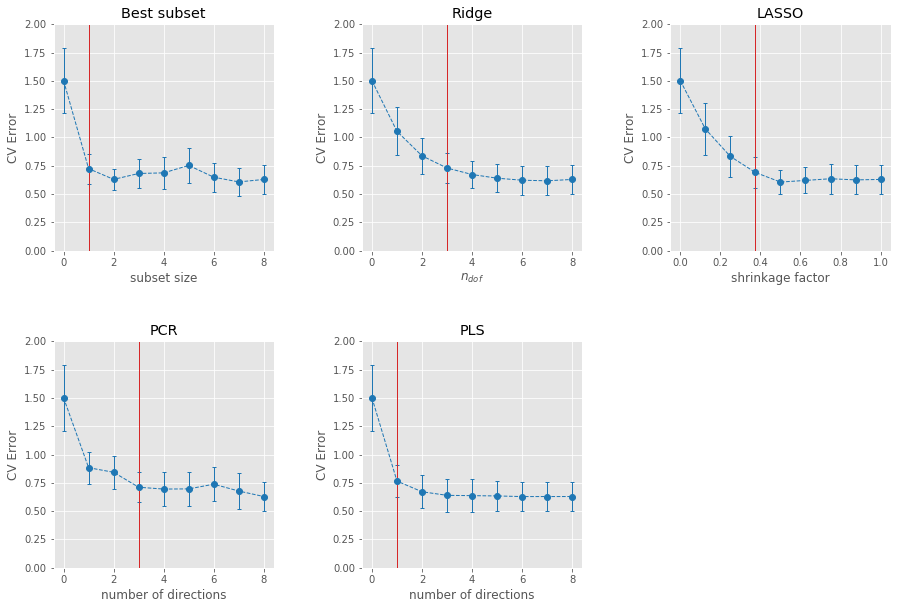

In [260]:
n_cols = 3

gs = gridspec.GridSpec(nrows=2, ncols=3)
gs.update(wspace=0.4, hspace=0.4)

fig = plt.figure(figsize=(15, 10))

for i, mod in enumerate(all_model_families[1:]):
    
    ax = fig.add_subplot(gs[i // 3, i%3], )
    ax.errorbar(mod['h_pars'], mod['error_means'], yerr = mod['error_stds'], fmt='--o', elinewidth = 1, \
             capsize = 2, **plt_style('dashed', 'thin', 'color1'),
             label=mod['model_name'])

    ax.plot([mod['best_par'], mod['best_par']], [0, 2], **plt_style('thin', 'color2'))
    ax.set_ylim((0.0, 2))
    ax.set_xlabel(mod['hpar'])
    ax.set_ylabel("CV Error")
    ax.set_title(mod['model_name'])

> Slight discrepancies with Figure 3.7. These might come from CV - we don't know how ESL folded the data.

> Overriding with hyperparameter values found in ELS:

In [261]:
all_model_families[1]['best_par'] = 2
all_model_families[2]['best_par'] = 5
all_model_families[4]['best_par'] = 7
all_model_families[5]['best_par'] = 2

for model_family in all_model_families:
    model_family['best_model'] = model_family['model_factory'](model_family['best_par'])
    model_family['best_model'].fit(X_train, Y_train)

### 1.6. Results table

In [ ]:
lm.

In [264]:
def model_features(mod, include_coefficients):
    
    scaled_mod = mod['regression']
    if isinstance(scaled_mod, LinearRegression):
        coeffs = scaled_mod.coef_[0, :]
        intercept = scaled_mod.intercept_[0]
    elif isinstance(scaled_mod, PLSRegression):
        coeffs = scaled_mod.coef_[:, 0]
        intercept = scaled_mod.y_mean_[0]
    else:
        coeffs = scaled_mod.coeffs[0, :]
        intercept = scaled_mod.intercept[0]
    
    test_error = mean_squared_error(mod.predict(X_test), Y_test)
    
    features = []
    if include_coefficients:
        features += ["{0:.3f}".format(intercept)] + ["" if coeff == 0 else "{0:.3f}".format(coeff) for coeff in coeffs]
        
    return features + [test_error]

def models_table(all_model_families, include_coefficients):
    
    features = []
    if include_coefficients:
        features += ['Intercept'] + list(data_train.columns)[:-1]
    features += ['Test Error']
    
    models_df = pd.DataFrame(columns=features)
    
    for model_family in all_model_families:
        mod = model_family['best_model']
        models_df.loc[model_family['model_name']] = model_features(mod, include_coefficients)
        
    return models_df.transpose()

In [265]:
models_table(all_model_families, include_coefficients=True)

,OLS,Best subset,Ridge,LASSO,PCR,PLS
Intercept,2.452,2.452,2.452,2.452,2.452,2.452
lcavol,0.711,0.774,0.433,0.558,0.566,0.436
lweight,0.290,0.349,0.252,0.187,0.321,0.360
age,-0.141,,-0.046,,-0.153,-0.021
lbph,0.210,,0.168,0.002,0.214,0.243
svi,0.307,,0.234,0.094,0.320,0.259
lcp,-0.287,,0.003,,-0.050,0.086
gleason,-0.021,,0.042,,0.227,0.006
pgg45,0.275,,0.134,,-0.063,0.084
Test Error,0.521274,0.492482,0.492498,0.478548,0.448309,0.53642


> I'm not quite sure where the numerical discrepancies in the coefficients come from - the coefficients in the table above are
> obtained by fitting over the whole training set, after demeaning and normalization
> of predictors.

> As for the PLS test error, I have double checked with an implementation from scratch, finding the same results.

## 2. `spam` dataset

### 2.1 Loading data

In [270]:
data_dir + 'spam.traintest'

'../../Data/spam.traintest'

In [271]:
data = pd.read_csv(data_dir + 'spam.data', delimiter = ' ', header=None)
train_test = pd.read_csv(data_dir + 'spam.traintest.txt', header=None)

data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [272]:
data_train, data_test = data[train_test[0]==0], data[train_test[0]==1]

X_train, Y_train = data_train.values[:, :-1], data_train.values[:, -1:]
X_test, Y_test = data_test.values[:, :-1], data_test.values[:, -1:]

N, p = X_train.shape

> It's not a great idea to re-apply LS regression methods to a classification problem, but that seems to be the task given.

### 2.2 List of models

In [273]:
def get_ols(x):
    return Pipeline([('norm', StandardScaler()), ('regression', LinearRegression(fit_intercept=True))])

def get_best_subset(k):
    if k == 0:
        return DummyRegressor()
    
    return Pipeline([('norm', StandardScaler()), ('regression', BestSubsetRegression(subset_size=k))])
    
def get_ridge(n_dofs):
    if n_dofs == 0:
        return DummyRegressor()
    
    return Pipeline([('norm', StandardScaler()), ('regression', RidgeRegressor(n_dofs=n_dofs))])

def get_lasso(shrinkage):
    if shrinkage == 0:
        return DummyRegressor()
    
    if shrinkage == 1:
        return LinearRegression()
    
    return Pipeline([('norm', StandardScaler()), ('regression', LassoRegressor(shrinkage=shrinkage))])

def get_pcr(n_components):
    if n_components == 0:
        return DummyRegressor()
    
    return Pipeline([('norm', StandardScaler()), ('regression', PcrRegressor(n_components=n_components))])

def get_pls(n_components):
    if n_components == 0:
        return DummyRegressor()   
    
    return Pipeline([('regression', PLSRegression(n_components=n_components, scale=True))])

In [274]:
all_model_families = [
    {'model_name': 'OLS', 'h_pars': [None], 'model_factory': get_ols},
    #{'model_name': 'Best subset', 'h_pars': np.arange(3), 'hpar': 'subset size', 'model_factory': get_best_subset},
    {'model_name': 'Ridge', 'h_pars': np.arange(0, p + 1, 3), 'hpar': '$n_{dof}$', 'model_factory': get_ridge},
    {'model_name': 'LASSO', 'h_pars': np.linspace(0, 1, 21), 'hpar': 'shrinkage factor', 'model_factory': get_lasso},
    {'model_name': 'PCR', 'h_pars': np.arange(0, 20, 1), 'hpar': 'number of directions', 'model_factory': get_pcr},
    {'model_name': 'PLS', 'h_pars':  np.arange(0, 20, 1), 'hpar': 'number of directions', 'model_factory': get_pls}
]

### 2.3. Hyperparameter tuning using CV

In [275]:
from sklearn.linear_model import Ridge, lars_path

In [276]:
for model_family in tqdm(all_model_families):
    
    error_means, error_stds = cv_error_stats(model_family['h_pars'], model_family['model_factory'],
                                         n_cv_folds=n_cv_folds, cv_seed=cv_seed, 
                                         X_train=X_train, Y_train=Y_train)
    
    one_sd_index = np.argmax(np.array(error_means) - np.array(error_stds) <= min(error_means))
    one_sd_par = model_family['h_pars'][one_sd_index]
    
    model_family['error_means'] = error_means
    model_family['error_stds'] = error_stds
    model_family['best_par'] = one_sd_par
    model_family['best_model'] = model_family['model_factory'](one_sd_par)
    model_family['best_model'].fit(X_train, Y_train)


100%|██████████| 5/5 [00:26<00:00,  4.84s/it]

### 1.5. A look at results

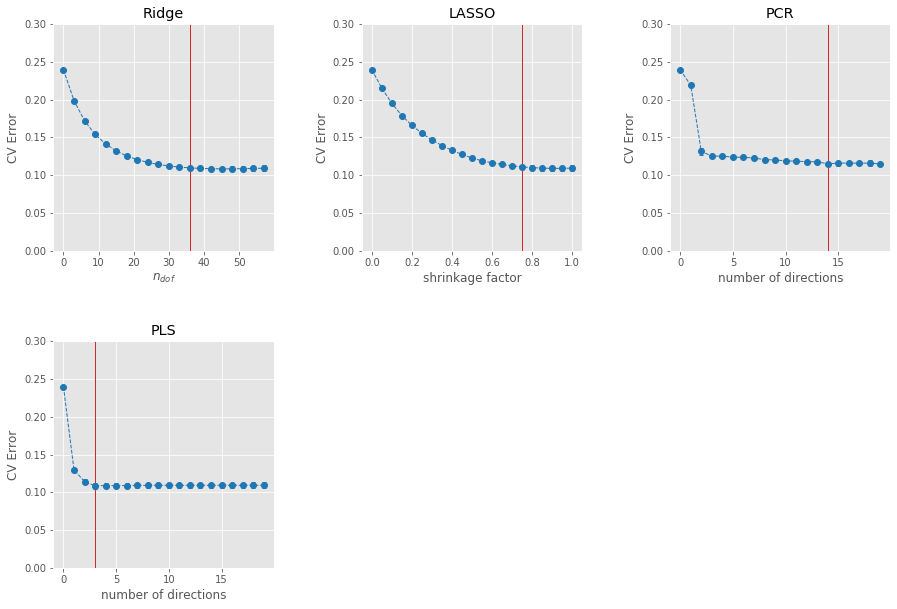

In [277]:
n_cols = 3

gs = gridspec.GridSpec(nrows=2, ncols=3)
gs.update(wspace=0.4, hspace=0.4)

fig = plt.figure(figsize=(15, 10))

for i, mod in enumerate(all_model_families[1:]):
    
    ax = fig.add_subplot(gs[i // 3, i%3], )
    ax.errorbar(mod['h_pars'], mod['error_means'], yerr = mod['error_stds'], fmt='--o', elinewidth = 1, \
             capsize = 2, **plt_style('dashed', 'thin', 'color1'),
             label=mod['model_name'])

    ax.plot([mod['best_par'], mod['best_par']], [0, 2], **plt_style('thin', 'color2'))
    ax.set_ylim((0.0, 0.3))
    ax.set_xlabel(mod['hpar'])
    ax.set_ylabel("CV Error")
    ax.set_title(mod['model_name'])

### 2.4. Results table

In [278]:
models_table(all_model_families, include_coefficients=False)

,OLS,Ridge,LASSO,PCR,PLS
Test Error,0.12123,0.117365,0.121591,0.122079,0.122531
